In [1]:
import sys
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

#Code from existing github repo provided by UC Irvine dataset
sys.path.append(os.getcwd())
import utils
import equalizer
from utils import cutCube
from equalizer import histEq


In [2]:
processed_training_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_train.npy"
processed_training_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_train_labels.npy"

processed_val_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_val.npy"
processed_val_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_val_labels.npy"

processed_test_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_test.npy"
processed_test_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/lungdeepfake/combined_tampered_scans_dataset_test_labels.npy"

In [3]:
from sklearn.preprocessing import LabelEncoder

# Loading Training data
loaded_train_data = np.load(processed_training_data)
loaded_train_labels = np.load(processed_training_labels)

# Loading Validation data
loaded_val_data = np.load(processed_val_data)
loaded_val_labels = np.load(processed_val_labels)

# Loading Test data
loaded_test_data = np.load(processed_test_data)
loaded_test_labels = np.load(processed_test_labels)

le = LabelEncoder()
transformed_train_labels = le.fit_transform(loaded_train_labels)
transformed_val_labels = le.transform(loaded_val_labels)
transformed_test_labels = le.transform(loaded_test_labels)

print(f'Shape of training data: {loaded_train_data.shape}, Shape of training labels: {transformed_train_labels.shape}')
print(f'Shape of validation data: {loaded_val_data.shape}, Shape of training labels: {transformed_val_labels.shape}')
print(f'Shape of training data: {loaded_test_data.shape}, Shape of training labels: {transformed_test_labels.shape}')


Shape of training data: (970, 32, 32, 32), Shape of training labels: (970,)
Shape of validation data: (33, 32, 32, 32), Shape of training labels: (33,)
Shape of training data: (33, 32, 32, 32), Shape of training labels: (33,)


In [4]:
train_middle_slices = loaded_train_data[:, 16, :, :]
val_middle_slices = loaded_val_data[:, 16, :, :]
test_middle_slices = loaded_test_data[:, 16, :, :]

print(f'Shape of middle slices: {train_middle_slices.shape}')
print(f'Shape of middle slices: {val_middle_slices.shape}')
print(f'Shape of middle slices: {test_middle_slices.shape}')


Shape of middle slices: (970, 32, 32)
Shape of middle slices: (33, 32, 32)
Shape of middle slices: (33, 32, 32)


In [5]:
train_images = train_middle_slices[:,:,:,np.newaxis]
val_images = val_middle_slices[:,:,:,np.newaxis]
test_images = test_middle_slices[:,:,:,np.newaxis]

print(f'Shape of training slices: {train_images.shape}')
print(f'Shape of validation slices: {val_images.shape}')
print(f'Shape of test slices: {test_images.shape}')


Shape of training slices: (970, 32, 32, 1)
Shape of validation slices: (33, 32, 32, 1)
Shape of test slices: (33, 32, 32, 1)


In [6]:
import tensorflow as tf
np.random.seed(1234)
tf.random.set_seed(1234)

2025-08-07 17:13:58.947720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(transformed_train_labels),
                                     y=transformed_train_labels)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.5511363636363636, 1: 1.0104166666666667, 2: 2.6944444444444446, 3: 1.2125}


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,327,492 (16.51 MB)

 Trainable params: 4,327,492 (16.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.3949 - loss: 1.3692 - val_accuracy: 0.8485 - val_loss: 0.8390
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.6553 - loss: 0.9017 - val_accuracy: 0.9091 - val_loss: 0.6462
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.7767 - loss: 0.6680 - val_accuracy: 0.8788 - val_loss: 0.4863
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8380 - loss: 0.5205 - val_accuracy: 0.9697 - val_loss: 0.3758
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8948 - loss: 0.4026 - val_accuracy: 0.9394 - val_loss: 0.3947
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9385 - loss: 0.2932 - val_accuracy: 0.9394 - val_loss: 0.3233
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9534 - loss: 0.2702 - val_accuracy: 0.9091 - val_loss: 0.3527
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9674 - loss: 0.2109 - val_accuracy: 0.9091 

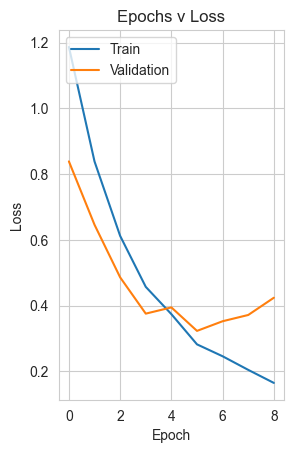

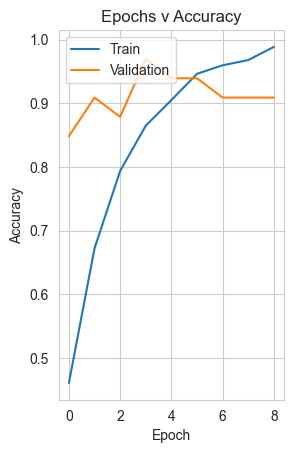

In [9]:
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
from tensorflow.keras import regularizers

cnn_v1 = tf.keras.Sequential()
cnn_v1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v1.add(layers.MaxPooling2D((2, 2)))
cnn_v1.add(layers.Dropout(0.3))

cnn_v1.add(layers.Flatten())
cnn_v1.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1.add(layers.Dropout(0.4))
cnn_v1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1.add(layers.Dropout(0.4))
cnn_v1.add(layers.Dense(4, activation='softmax'))

cnn_v1.build(input_shape=(None, 32, 32, 1))
cnn_v1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v1.summary()

cnn_v1_history = cnn_v1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v1_history.history['loss'])
plt.plot(cnn_v1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v1_history.history['accuracy'])
plt.plot(cnn_v1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336,740 (16.54 MB)

 Trainable params: 4,336,740 (16.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.3410 - loss: 1.3587 - val_accuracy: 0.7273 - val_loss: 0.9212
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6089 - loss: 0.9240 - val_accuracy: 0.8788 - val_loss: 0.6120
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7756 - loss: 0.6255 - val_accuracy: 0.9697 - val_loss: 0.4279
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8810 - loss: 0.4144 - val_accuracy: 0.9394 - val_loss: 0.4054
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9156 - loss: 0.3215 - val_accuracy: 0.9091 - val_loss: 0.4244
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9515 - loss: 0.2476 - val_accuracy: 0.9091 - val_loss: 0.4602
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9726 - loss: 0.1907 - val_accuracy: 0.9394 - val_loss: 0.5443
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9714 - loss: 0.1991 - val_accuracy: 0.

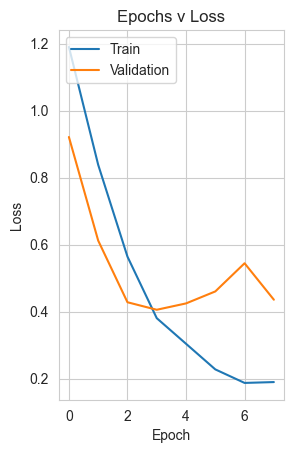

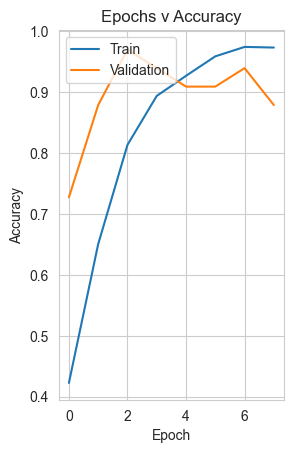

In [10]:
import tensorflow as tf
from keras import models
from keras import layers
tf.keras.backend.clear_session()
from tensorflow.keras import regularizers

cnn_v1_1 = tf.keras.Sequential()
cnn_v1_1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v1_1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v1_1.add(layers.MaxPooling2D((2, 2)))
cnn_v1_1.add(layers.Dropout(0.3))

cnn_v1_1.add(layers.Flatten())
cnn_v1_1.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1_1.add(layers.Dropout(0.4))
cnn_v1_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1_1.add(layers.Dropout(0.4))
cnn_v1_1.add(layers.Dense(4, activation='softmax'))

cnn_v1_1.build(input_shape=(None, 32, 32, 1))
cnn_v1_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v1_1.summary()

cnn_v1_1_history = cnn_v1_1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1_1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1_1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v1_1_history.history['loss'])
plt.plot(cnn_v1_1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v1_1_history.history['accuracy'])
plt.plot(cnn_v1_1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,295,012 (8.75 MB)

 Trainable params: 2,295,012 (8.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.3216 - loss: 1.4326 - val_accuracy: 0.8182 - val_loss: 0.9342
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5765 - loss: 0.9875 - val_accuracy: 0.7879 - val_loss: 0.8150
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.6625 - loss: 0.8044 - val_accuracy: 0.9091 - val_loss: 0.5012
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7706 - loss: 0.6592 - val_accuracy: 0.9394 - val_loss: 0.3484
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.8036 - loss: 0.5623 - val_accuracy: 0.9394 - val_loss: 0.3750
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8809 - loss: 0.3722 - val_accuracy: 0.9091 - val_loss: 0.3450
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9010 - loss: 0.3294 - val_accuracy: 0.9394 - val_loss: 0.4251
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9149 - loss: 0.3096 - val_accuracy: 0.

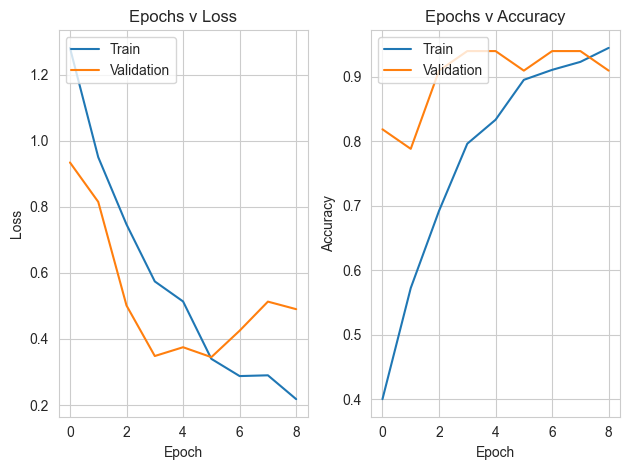

In [11]:
import tensorflow as tf
from keras import layers
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()

cnn_v2 = tf.keras.Sequential()
cnn_v2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v2.add(layers.MaxPooling2D((2, 2)))
cnn_v2.add(layers.Dropout(0.3))

cnn_v2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2a'))
cnn_v2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2b'))
cnn_v2.add(layers.MaxPooling2D((2, 2)))
cnn_v2.add(layers.Dropout(0.3))

cnn_v2.add(layers.Flatten())
cnn_v2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v2.add(layers.Dropout(0.4))
cnn_v2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v2.add(layers.Dropout(0.4))
cnn_v2.add(layers.Dense(4, activation='softmax'))

cnn_v2.build(input_shape=(None, 32, 32, 1))
cnn_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v2.summary()

cnn_v2_history = cnn_v2.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v2.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v2.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v2_history.history['loss'])
plt.plot(cnn_v2_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_v2_history.history['accuracy'])
plt.plot(cnn_v2_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,876 (5.60 MB)

 Trainable params: 1,467,876 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.3165 - loss: 1.4599 - val_accuracy: 0.6061 - val_loss: 1.0685
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5383 - loss: 1.0406 - val_accuracy: 0.6061 - val_loss: 0.9446
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.6099 - loss: 0.8583 - val_accuracy: 0.7879 - val_loss: 0.6398
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7239 - loss: 0.7005 - val_accuracy: 0.8485 - val_loss: 0.4826
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7584 - loss: 0.6391 - val_accuracy: 0.8182 - val_loss: 0.6362
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8015 - loss: 0.5889 - val_accuracy: 0.8485 - val_loss: 0.4977
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8523 - loss: 0.4808 - val_accuracy: 0.8485 - val_loss: 0.3608
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8531 - loss: 0.4051 - val_accuracy: 0.

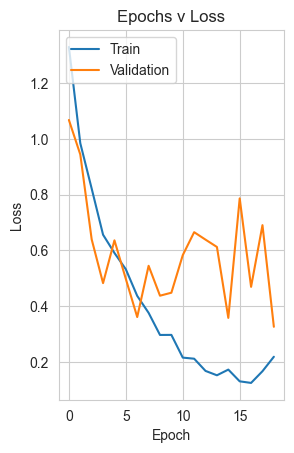

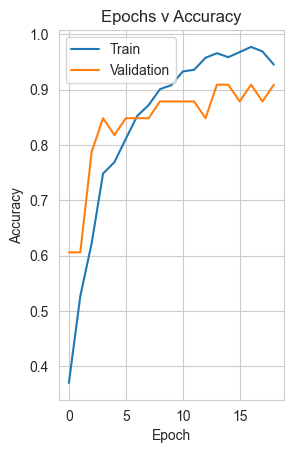

In [12]:
import tensorflow as tf
from keras import layers
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()

cnn_v3 = tf.keras.Sequential()
cnn_v3.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v3.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Dropout(0.3))

cnn_v3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2a'))
cnn_v3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Dropout(0.3))

cnn_v3.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_3a'))
cnn_v3.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_3b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Flatten())
cnn_v3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v3.add(layers.Dropout(0.4))
cnn_v3.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v3.add(layers.Dropout(0.4))
cnn_v3.add(layers.Dense(4, activation='softmax'))

cnn_v3.build(input_shape=(None, 32, 32, 1))
cnn_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cnn_v3.summary()
cnn_v3_history = cnn_v3.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v3.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v3.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v3_history.history['loss'])
plt.plot(cnn_v3_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v3_history.history['accuracy'])
plt.plot(cnn_v3_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
test_loss, test_acc = cnn_v1.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v1 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8163 - loss: 0.7690
CNN v1 Test loss: 0.762512743473053, Test accuracy: 0.8181818127632141


In [14]:
test_loss, test_acc = cnn_v1_1.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v1.1 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7244 - loss: 0.7535
CNN v1.1 Test loss: 0.7471938729286194, Test accuracy: 0.7272727489471436


In [15]:
test_loss, test_acc = cnn_v2.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v2 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7655 - loss: 0.6862 
CNN v2 Test loss: 0.6872137784957886, Test accuracy: 0.7575757503509521


In [16]:
test_loss, test_acc = cnn_v3.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v3 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7551 - loss: 1.1141
CNN v3 Test loss: 1.1031521558761597, Test accuracy: 0.7575757503509521


In [17]:
from sklearn.metrics import classification_report

y_pred = cnn_v1.predict(val_images)
y_pred_classes_1 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_val_labels, y_pred_classes_1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      1.00      1.00         9
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         7

    accuracy                           0.97        33
   macro avg       0.98      0.92      0.94        33
weighted avg       0.97      0.97      0.97        33



In [18]:
y_pred = cnn_v1_1.predict(test_images)
y_pred_classes_1_1 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_1_1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.58      0.88      0.70         8
           2       0.50      1.00      0.67         3
           3       0.67      0.25      0.36         8

    accuracy                           0.73        33
   macro avg       0.69      0.75      0.66        33
weighted avg       0.77      0.73      0.71        33



In [19]:
y_pred = cnn_v2.predict(test_images)
y_pred_classes_2 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_2))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x14a4df4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.67      0.75      0.71         8
           2       0.50      0.67      0.5

In [20]:
y_pred = cnn_v3.predict(val_images)
y_pred_classes_3 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_val_labels, y_pred_classes_3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.90      1.00      0.95         9
           2       1.00      0.67      0.80         3
           3       1.00      0.71      0.83         7

    accuracy                           0.91        33
   macro avg       0.94      0.85      0.88        33
weighted avg       0.92      0.91      0.90        33



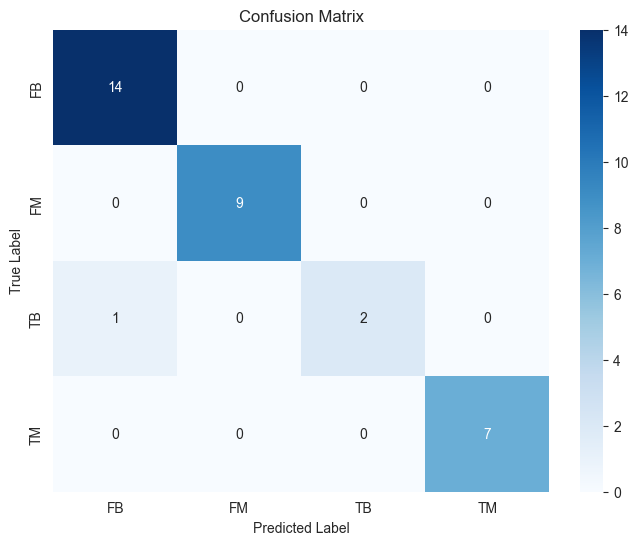

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_1)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

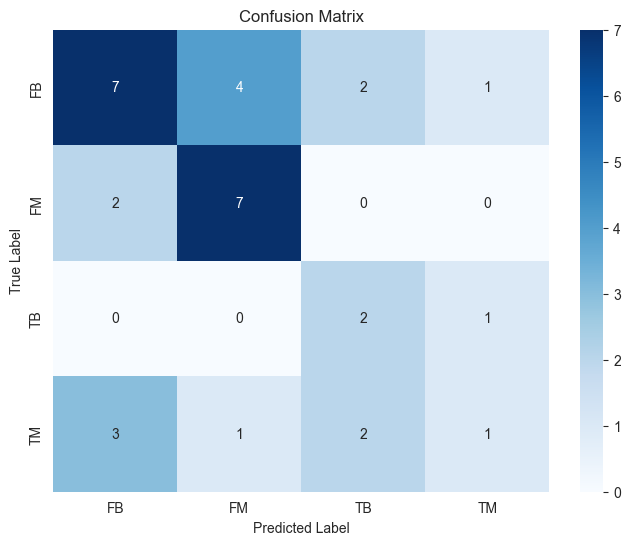

In [22]:
# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_1_1)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

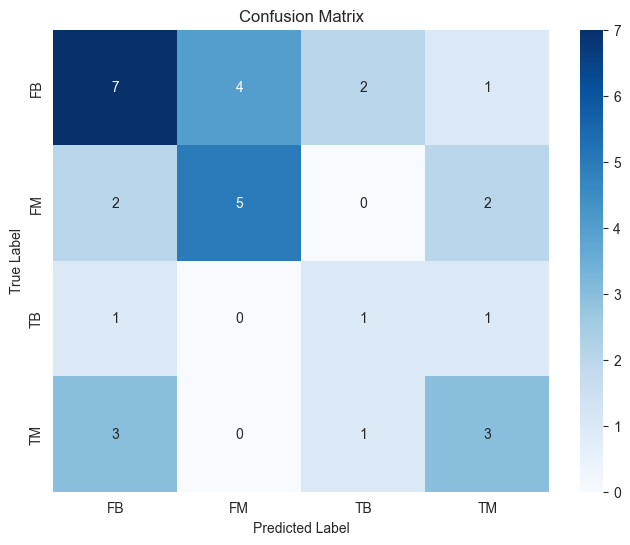

In [23]:
# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_2)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

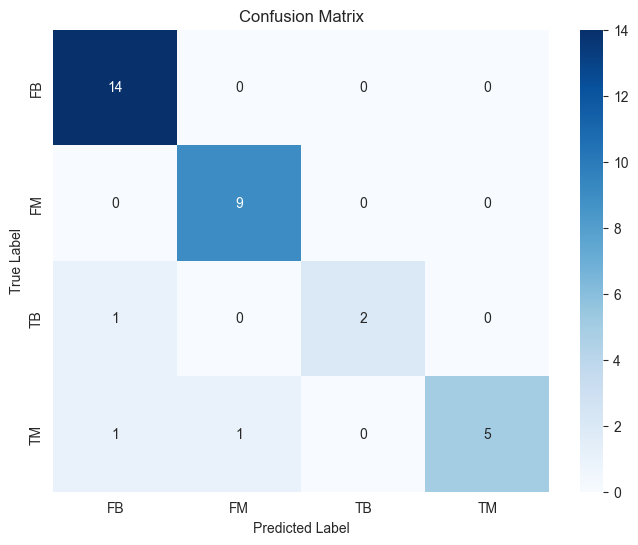

In [24]:
# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_3)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

3D CNN Experimentation (Initial model built by Justin)

In [25]:
img_res=(32, 32, 32)
train_image_data = loaded_train_data.reshape((len(loaded_train_data), img_res[0], img_res[1], img_res[2], 1))
val_image_data = loaded_val_data.reshape((len(loaded_val_data), img_res[0], img_res[1], img_res[2], 1))
test_image_data = loaded_test_data.reshape((len(loaded_test_data), img_res[0], img_res[1], img_res[2], 1))
print(train_image_data.shape, val_image_data.shape,test_image_data.shape)

(970, 32, 32, 32, 1) (33, 32, 32, 32, 1) (33, 32, 32, 32, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,112,324 (256.01 MB)

 Trainable params: 67,112,324 (256.01 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.4456 - loss: 7.2460 - val_accuracy: 0.7879 - val_loss: 0.8586
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8271 - loss: 0.6384 - val_accuracy: 0.8182 - val_loss: 0.5571
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9216 - loss: 0.2935 - val_accuracy: 0.8485 - val_loss: 0.4710
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9790 - loss: 0.1383 - val_accuracy: 0.8788 - val_loss: 0.4264
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9988 - loss: 0.0545 - val_accuracy: 0.9091 - val_loss: 0.4560
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 1.0000 - loss: 0.0262 - val_accuracy: 0.8788 - val_loss: 0.4648
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.8788 - val_loss: 0.4788
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 1.

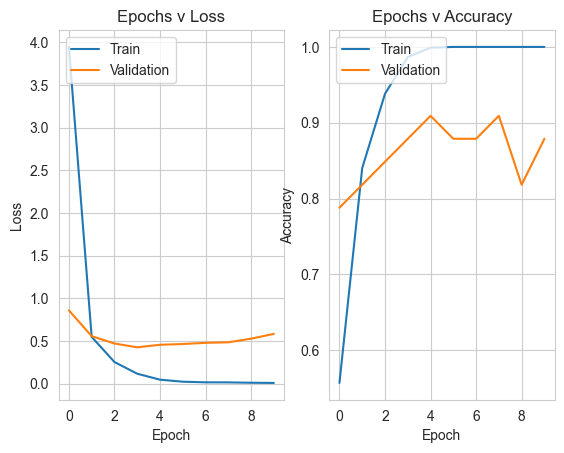

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 1.0000 - loss: 0.0358
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9081 - loss: 0.4538 

Train Accuracy: 1.00
Validation Accuracy: 0.91


In [26]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
# initialize model
cnn_3D_v1 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v1.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v1.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v1.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v1.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v1.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v1.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v1.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v1.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v1_history = cnn_3D_v1.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves

plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v1_history.history['loss'])
plt.plot(cnn_3D_v1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v1_history.history['accuracy'])
plt.plot(cnn_3D_v1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v1.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v1.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,140,004 (256.12 MB)

 Trainable params: 67,140,004 (256.12 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.2878 - loss: 4.9808 - val_accuracy: 0.4242 - val_loss: 1.3731
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.4327 - loss: 1.3659 - val_accuracy: 0.4242 - val_loss: 1.3452
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.4327 - loss: 1.3371 - val_accuracy: 0.4242 - val_loss: 1.3170
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 152s 5s/step - accuracy: 0.4327 - loss: 1.3092 - val_accuracy: 0.4242 - val_loss: 1.2940
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.4327 - loss: 1.2877 - val_accuracy: 0.4242 - val_loss: 1.2798
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.4327 - loss: 1.2754 - val_accuracy: 0.4242 - val_loss: 1.2733
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


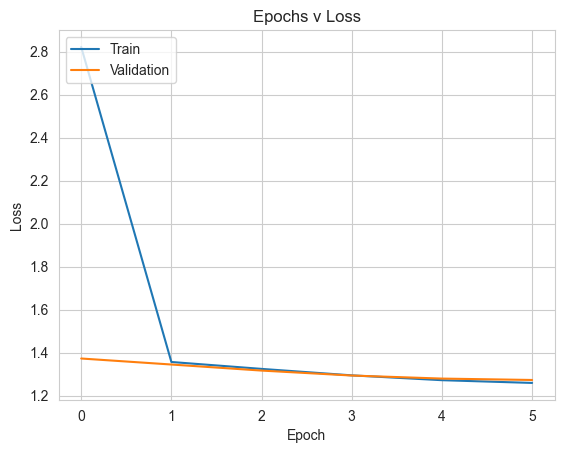

31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - accuracy: 0.3956 - loss: 1.3752
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.4287 - loss: 1.3725

Train Accuracy: 0.45
Validation Accuracy: 0.42


In [27]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
# initialize model
tf.keras.backend.clear_session()

cnn_3D_v2 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v2.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v2.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v2.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v2.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v2.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v2.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v2.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v2.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v2.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
history = cnn_3D_v2.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v2.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v2.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv3D)                │ (None, 16, 16, 16, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv3D)                │ (None, 16, 16, 16, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,974,372 (64.75 MB)

 Trainable params: 16,974,372 (64.75 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.3983 - loss: 1.6710 - val_accuracy: 0.6667 - val_loss: 1.1170
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accuracy: 0.6367 - loss: 0.9743 - val_accuracy: 0.7576 - val_loss: 0.7522
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.7400 - loss: 0.6685 - val_accuracy: 0.7879 - val_loss: 0.5706
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.8346 - loss: 0.4373 - val_accuracy: 0.8485 - val_loss: 0.2937
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 0.8930 - loss: 0.2601 - val_accuracy: 0.8788 - val_loss: 0.3017
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.9404 - loss: 0.1819 - val_accuracy: 0.8485 - val_loss: 0.3006
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accuracy: 0.9599 - loss: 0.1009 - val_accuracy: 0.9091 - val_loss: 0.5002
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accu

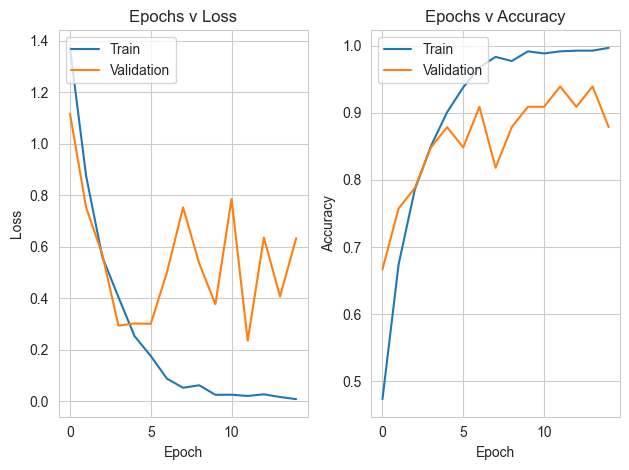

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 711ms/step - accuracy: 0.9988 - loss: 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9388 - loss: 0.2373

Train Accuracy: 1.00
Validation Accuracy: 0.94


In [28]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
tf.keras.backend.clear_session()

# initialize model
cnn_3D_v3 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v3.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v3.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v3.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

cnn_3D_v3.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2a',
  activation='relu'
))
cnn_3D_v3.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2b',
  activation='relu'
))
cnn_3D_v3.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v3.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v3.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v3.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v3.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v3.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v3.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v3_history = cnn_3D_v3.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v3_history.history['loss'])
plt.plot(cnn_3D_v3_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v3_history.history['accuracy'])
plt.plot(cnn_3D_v3_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v3.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v3.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv3D)                │ (None, 16, 16, 16, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv3D)                │ (None, 16, 16, 16, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv3D)                │ (None, 8, 8, 8, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv3D)                │ (None, 8, 8, 8, 128)   │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,415,396 (131.28 MB)

 Trainable params: 34,415,396 (131.28 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 232s 7s/step - accuracy: 0.3989 - loss: 1.7438 - val_accuracy: 0.5758 - val_loss: 1.1829
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.6325 - loss: 1.0977 - val_accuracy: 0.6970 - val_loss: 0.8406
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - accuracy: 0.6795 - loss: 0.7614 - val_accuracy: 0.7879 - val_loss: 0.6311
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.7626 - loss: 0.6139 - val_accuracy: 0.8485 - val_loss: 0.4049
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 217s 7s/step - accuracy: 0.8259 - loss: 0.4482 - val_accuracy: 0.8788 - val_loss: 0.4230
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.8955 - loss: 0.2597 - val_accuracy: 0.8182 - val_loss: 0.7073
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 217s 7s/step - accuracy: 0.9418 - loss: 0.1326 - val_accuracy: 0.8788 - val_loss: 0.6846
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 217s 7s/step - accu

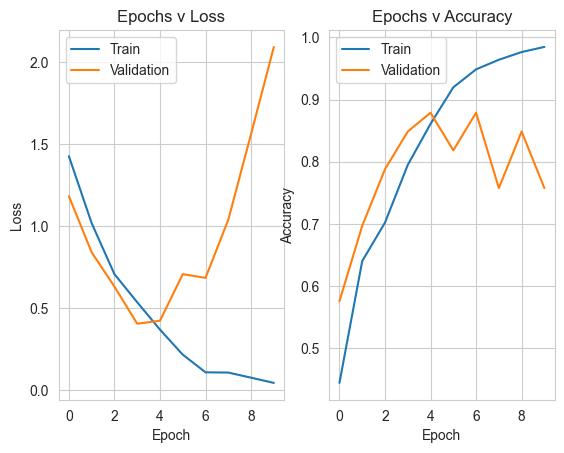

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 933ms/step - accuracy: 0.8885 - loss: 0.2727
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8775 - loss: 0.4222

Train Accuracy: 0.90
Validation Accuracy: 0.88


In [29]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
tf.keras.backend.clear_session()

# initialize model
cnn_3D_v4 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v4.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v4.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v4.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

cnn_3D_v4.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2a',
  activation='relu'
))
cnn_3D_v4.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2b',
  activation='relu'
))
cnn_3D_v4.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v4.add(layers.Dropout(rate=0.4))

cnn_3D_v4.add(layers.Conv3D(
  filters=128,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_3a',
  activation='relu'
))
cnn_3D_v4.add(layers.Conv3D(
  filters=128,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_3b',
  activation='relu'
))

# add a flattening layer
cnn_3D_v4.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v4.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v4.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v4.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v4.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v4_history = cnn_3D_v4.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v4_history.history['loss'])
plt.plot(cnn_3D_v4_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v4_history.history['accuracy'])
plt.plot(cnn_3D_v4_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v4.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v4.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

In [30]:
test_loss, test_acc = cnn_3D_v1.evaluate(test_image_data, transformed_test_labels, verbose=1)
print(f"3D CNN v1 Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7348 - loss: 0.7780
3D CNN v1 Test Accuracy: 0.73


In [31]:
test_loss, test_acc = cnn_3D_v3.evaluate(test_image_data, transformed_test_labels, verbose=1)
print(f"3D CNN v3 Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7551 - loss: 1.3947
3D CNN v3 Test Accuracy: 0.76


In [32]:
test_loss, test_acc = cnn_3D_v4.evaluate(test_image_data, transformed_test_labels, verbose=1)
print(f"3D CNN v4 Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6736 - loss: 1.4799
3D CNN v4 Test Accuracy: 0.67


In [33]:
from sklearn.metrics import classification_report

y_pred = cnn_3D_v1.predict(test_image_data)
y_pred_classes_1 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.58      0.88      0.70         8
           2       0.50      0.33      0.40         3
           3       0.50      0.25      0.33         8

    accuracy                           0.73        33
   macro avg       0.63      0.61      0.60        33
weighted avg       0.70      0.73      0.70        33



In [34]:
y_pred = cnn_3D_v3.predict(test_image_data)
y_pred_classes_3 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.58      0.88      0.70         8
           2       0.60      1.00      0.75         3
           3       1.00      0.38      0.55         8

    accuracy                           0.76        33
   macro avg       0.78      0.78      0.72        33
weighted avg       0.83      0.76      0.75        33



In [35]:
y_pred = cnn_3D_v4.predict(test_image_data)
y_pred_classes_4 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_4))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        14
           1       0.58      0.88      0.70         8
           2       0.00      0.00      0.00         3
           3       1.00      0.25      0.40         8

    accuracy                           0.67        33
   macro avg       0.58      0.51      0.48        33
weighted avg       0.69      0.67      0.61        33

